# A simple maze

This notebook covers the implementation of a simple _maze_ (or _grid-world_) to facilitate experimenting with basic dynamic programming algorithms, such as value iteration and policy iteration.

The building blocks defined in this notebook can be reused in another notebook using module importer from __[ipynb](https://github.com/ipython/ipynb)__ package, see __[here](https://ipynb.readthedocs.io/en/latest/)__. Import is best done _definitions only_ so that this notebook is not exceuted and output of the notebook does not get cluttered with examples provided here. For instance:

```python
from ipynb.fs.defs._filename_of_this_notebook_ import (
    Maze, Movement,
    plot_maze, plot_policy_actions, plot_state_rewards, plot_state_values
)
```  

With this, import statements, class and function definitions as well as constants defined in ALL_CAPS will get imported. 

In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import seaborn as sns

## The maze 

### Maze class

We define a simple `Maze` class to contain the structure of the grid world. In addition to the structure of the maze, such as size, walls and terminal states, we consider the rewards received when exploring the maze to be a part of the maze definition. Hence the class defines the reward received when entering a state, and takes into account discounting and living cost.

State values (determined by some algorithm, such as value iteration) or resulting policy are not considered to be a part of the maze, and are managed in separate data structures outside the `Maze` class.

The structure of the maze is internally represented as Numpy [ndarrays](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) and states can be indexed with `(x,y)` tuples, starting from top left corner as `(0,0)`.

`Maze` constructor takes a `maze_config` dictionary that defines the maze structure as an argument and stores the needed internal structures. 

In addition, we give the value of discounting parameter $\gamma$ and a living cost parameter as arguments to Maze class constructor.

See below for example use.

In [2]:
class Maze:
    def __init__(self, maze_config, *, gamma=1, living_cost=0):

        self.gamma = gamma
        self.living_cost = living_cost
        
        self.size = maze_config['size']

        self.walls = np.full(self.size, False, dtype=bool)
        self.walls[tuple(zip(*maze_config['walls']))] = True
        
        # Note: default reward for entering a state is 0
        
        self.rewards = np.full(self.size, 0, dtype=np.float32)
        self.rewards[self.walls] = np.nan
        
        for key in maze_config['rewards']:
            self.rewards[key] = maze_config['rewards'][key]
        
        self.terminal = np.full(self.size, False, dtype=bool)
        self.terminal[tuple(zip(*maze_config['terminal_states']))] = True
        
        self.states = {}
        self.grid_index = []
        for index, wall in np.ndenumerate(self.walls):
            if not wall:
                self.grid_index.append(index)
                self.states[index] = index
        
        self.state_count = len(self.grid_index)

    def get_iterator(self, param):
        return MazeIterator(self, param)
    
    def get_as_list(self, param):
        return [ r for r in self.get_iterator(param) ]
    
    def is_valid_state(self, state):
        # short circuit order
        return (0 <= state[0] <= self.size[0] - 1 and 0 <= state[1] <= self.size[1] - 1) and (not self.walls[state])

### Maze iterator

In addition, we define an __[iterator](https://wiki.python.org/moin/Iterator)__ to enumerate the maze grid states that the agent can enter (i.e. the ones that do not contain walls). Even though we will be doing a lot of iterating, this is not only for convenience,  but also to help avoid bugs potentially difficult to trace: To guarantee, that we always consider the states in same order, even when processing data structures external to the maze.

The iterator can be used to iterate maze properties with string references to `Maze` class properties, e.g.:
```
for state in maze.get_iterator("states"):
    # each state 
    
print(list(maze.get_iterator('rewards')))

```    
Or to iterate external data structures in the order defined by `Maze.grid_index`:
```
initial_values = { state:0 for state in maze.get_iterator("states") }
list(maze.get_iterator(initial_values))
```
Or even
```
maze.get_as_list(initial_values)
```

In [3]:
class MazeIterator:
    def __init__(self, maze, param):
        self.grid_index = maze.grid_index
        self.max = len(self.grid_index)
        
        if type(param) is str:
            self.param = getattr(maze, param)
        else:
            self.param = param
        
        self.n = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.n >= self.max:
            raise StopIteration
 
        res = self.param[self.grid_index[self.n]]
        
        self.n += 1
        return res

## Movement within the maze

We collect the logic of agent's movement within the grid world into `Movement` utility class. In addition, together with `Maze`, `Movement`class enables determining the transition probabilities for when we analyze the maze as a Markov Decision Process (MDP).

The agent may attempt to move to one of four directions: `NORTH`, `EAST`, `SOUTH` and `WEST`. 

Movement is noisy. Attempt to move to certain direction (e.g. _north_) may result in ending up left of the intended direction (e.g. _west_ if intended direction was _north_), or right of the direction (e.g. _east_).

For action _north_, `movement.get_direction_probs(action)` would return directions _west_, _north_ and _east_, with probabilities 0.1, 0.8 and 0.1, respectively, assuming $noise = 0.2$. 

If there is a wall blocking the move or the move ends up outside the maze grid, `move_from` returns to current state. Otherwise, the new state in the move direction is returned. To see where a move from current state to given direction would end up, agent would perform

```
s_prime = movement.move_from(current_state, move_direction)
```

Utilizing the class, an agent can analyze the movement directions and find probabilities associated with follow up states when trying to perform a particular `action`. For instance, to analyze an action available in a state, an agent could perform:

```
for move_direction, p_move in movement.get_direction_probs(action):
    
    s_prime = movement.move_from(state, move_direction)
    reward = maze.living_cost + maze.rewards[s_prime]
    s_prime_value = state_values[s_prime]
    ...
```


In [4]:
class Movement:

    NORTH = 0
    EAST = 1
    SOUTH = 2
    WEST = 3

    actions = [ NORTH, EAST, SOUTH, WEST ]
    action_names = [ "NORTH", "EAST", "SOUTH", "WEST" ]
    direction_arrows = [ '\u2191','\u2192','\u2193','\u2190', '\u25aa', ''] # up, right, down, left, small square, empty

    def __init__(self, maze, *, noise=0.2):
        
        self.maze = maze
        self.NOISE = noise
        
        self.noisy_moves = [
            self._adjust_left,
            self._adjust_none,
            self._adjust_right
        ]
        self.noisy_move_probs = [self.NOISE / 2, 1 - self.NOISE, self.NOISE / 2] # left, straight, right
        

    def _adjust_left(cls, direction):
        return (cls.actions.index(direction) + len(cls.actions) - 1) % len(cls.actions)

    def _adjust_none(cls, direction):
        return direction
    
    def _adjust_right(cls, direction):
        return (cls.actions.index(direction) + 1) % len(cls.actions)

    def get_direction_probs(self, action):
        dirs = []
        for j, _ in enumerate(self.noisy_moves):
            p_move = self.noisy_move_probs[j]
            move_direction = self.noisy_moves[j](action)
            
            dirs.append((move_direction, p_move))
        
        return dirs
    
    def _get_move_target(self, from_state, action):

        if action == Movement.NORTH:
            target_state = (from_state[0] - 1, from_state[1])
        elif action == Movement.EAST:
            target_state = (from_state[0], from_state[1] + 1)
        elif action == Movement.SOUTH:
            target_state = (from_state[0] + 1, from_state[1])
        elif action == Movement.WEST:
            target_state = (from_state[0], from_state[1] - 1)

        return target_state

    def move_from(self, from_state, action):

        target_state = self._get_move_target(from_state, action)

        # check if trying to move outside the maze or against a wall
        # and in that case stay in current position
        
        if self.maze.is_valid_state(target_state):
            return target_state
        else:
            return from_state        

## Visualizing the maze

We define helper functions for visualizing the maze. First, `plot_maze_grid` is the utility function to create a __[Seaborn heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap)__ based visualization of the maze and is used by the other helper functions providing different annotations and colormaps for customization.

To annotate the grid with rewards, we use `plot_state_rewards`. To show current state values on the grid, we pass the state values to `plot_state_values`. Similarly, `plot_policy_actions` allows for plotting direction arrows corresponding to a policy given as argument on the maze grid.

Finally, `plot_maze` will allow for plotting current state values and policy actions side by side in two subplots.

We define two colormaps as `LinearSegmentedColormap` objects that are instantiated by giving a list of preselected colors. First colormap, `CM_VALUES` is used for representing the walls and terminal states of the maze. Here it is assumed that entering good terminal states provides a positive (colored light green) and entering bad terminal states a negative reward (colored light red) . The other, `CM_ACTIONS` is used as a background to gently differientate policy actions. The colormaps are illustrated below.

Some rudimentary scaling of annotation texts is done to facilitate plotting of diffent size grids.

In [5]:
# a figure size constant that would create a 1280 x 720 image with matplotlib default density of 100 dpi

FIG_SIZE=(12.8, 7.2)
FIG_DPI=100

<AxesSubplot:>

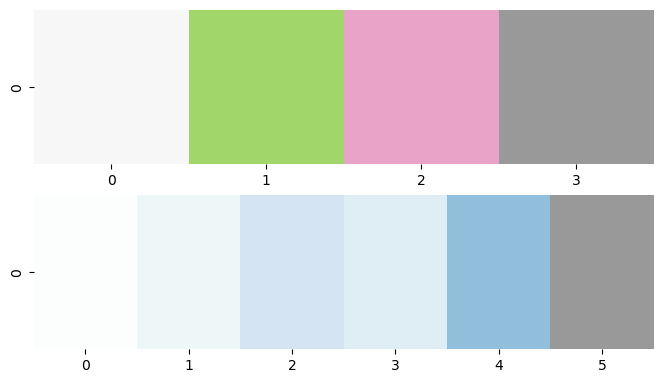

In [6]:
VALUE_COLORS = ['#f7f7f7','#a1d76a', '#e9a3c9', '#999999'] # NONE, GOOD, BAD, WALL
CM_VALUES = LinearSegmentedColormap.from_list("value", VALUE_COLORS, N=4)

ACTION_COLORS = ['#fcfefe', '#edf7f8', '#d5e4f2', '#dfedf5','#91bfdb','#999999'] # N, E, S, W, TERMINAL, WALL 
CM_ACTIONS = LinearSegmentedColormap.from_list("action", ACTION_COLORS, N=6)

fig = plt.figure(figsize=tuple(i/1.6 for i in FIG_SIZE), dpi=FIG_DPI)

ax = fig.add_subplot(2, 1, 1)
sns.heatmap([list(range(0,4))], fmt='', cmap=CM_VALUES, \
                 linewidths=0, rasterized=False, \
                 cbar=False, ax=ax)

ax = fig.add_subplot(2, 1, 2)
sns.heatmap([list(range(0,6))], fmt='', cmap=CM_ACTIONS, \
                 linewidths=0, rasterized=False, \
                 cbar=False, ax=ax)

In [7]:
def scale_text(maze_size):
    return 18 / max(1, max(maze_size) / 6)

def scale_arrows(maze_size):
    return 32 / max(1, max(maze_size) / 8)

In [8]:
def plot_maze_grid(values, annotations, *, annot_kws={'size': 16}, cm, ax=None):
    
    if not ax:
        plt.figure(figsize=FIG_SIZE, dpi=FIG_DPI)
        
    ax = sns.heatmap(values, annot=annotations, annot_kws=annot_kws, fmt='', cmap=cm, \
                     square=True, linewidths=0.01, linecolor='#5f5f5f', rasterized=False, \
                     cbar=False, ax=ax)
    ax.tick_params(left=False, bottom=False) 
    ax.tick_params(labelleft=False, labelbottom=False)

    sns.despine(ax=ax, top=False, right=False, left=False, bottom=False)
    
    return ax

In [9]:
def plot_state_rewards(maze, *, ax=None, cm=CM_VALUES):

    NONE = 0
    GOOD = 1
    BAD = 2
    WALL = 3

    cells = np.full(maze.size, NONE)
    cells[maze.rewards > 0] = GOOD
    cells[maze.rewards < 0] = BAD
    cells[maze.walls] = WALL
   
    annot_text = np.full(maze.size, '', dtype=object)
    
    keys = maze.get_as_list("states")

    for key in keys:
        r = maze.rewards[key] 
        annot_text[key] = f"{r + maze.living_cost:.3f}"

    annot_kws={'size': scale_text(maze.size)}
    
    plot_maze_grid(cells, annot_text, annot_kws=annot_kws, cm=cm, ax=ax)

In [10]:
def plot_state_values(maze, state_values, *, ax=None, cm=CM_VALUES):

    NONE = 0
    GOOD = 1
    BAD = 2
    WALL = 3
    
    cells = np.full(maze.size, NONE)
    cells[maze.rewards > 0] = GOOD
    cells[maze.rewards < 0] = BAD
    cells[maze.walls] = WALL
    
    annot_text = np.full(maze.size, '', dtype=object)

    for a, key in enumerate(state_values):
        val = state_values[key]
        annot_text[key] =  f"{val:.3f}"
    
    annot_kws={'size': scale_text(maze.size)}
    
    plot_maze_grid(cells, annot_text, annot_kws=annot_kws, cm=cm, ax=ax)

In [11]:
def plot_policy_actions(maze, policy, *, ax=None, cm=CM_ACTIONS):
    
    # 0...3 = NORTH, EAST, ...
    TERMINAL = 4
    WALL = 5
    
    cells = np.full(maze.size, WALL)
    for a, key in enumerate(policy):
        cells[key] = policy[key]

    cells[maze.terminal] = TERMINAL

    ax = plot_maze_grid(cells, False, cm=cm, ax=ax)
    
    arrow_size = scale_arrows(maze.size)
    
    for index, c in np.ndenumerate(cells):
        arrow = Movement.direction_arrows[c]
        ax.text(index[1] + 0.5, index[0] + 0.5, arrow, size=arrow_size, ha='center', va='center')

In [12]:
def plot_maze(maze, state_values, policy):
    fig = plt.figure(figsize=FIG_SIZE, dpi=FIG_DPI)

    ax = fig.add_subplot(1, 2, 1)
    plot_state_values(maze, state_values, ax=ax)

    ax = fig.add_subplot(1, 2, 2)
    plot_policy_actions(maze, policy, ax=ax)

    fig.tight_layout()

## Example use: Canonical maze

To instantiate a `maze`, we define a `maze_config` dictionary, that defines the size of the maze, location of walls within the grid, the terminal states and rewards associated when moving to the state in question.

To illustrate, we create the "canonical maze" used commonly in reinforcement learning examples and plot the rewards associated with states.

In [13]:
maze_config = {
    'size': (3, 4),
    'walls': [(1,1)],
    'terminal_states': [(0,3), (1,3)],
    'rewards': {
        (0,3): 1,
        (1,3): -1
    }
}
maze = Maze(maze_config, gamma=1, living_cost = 0)

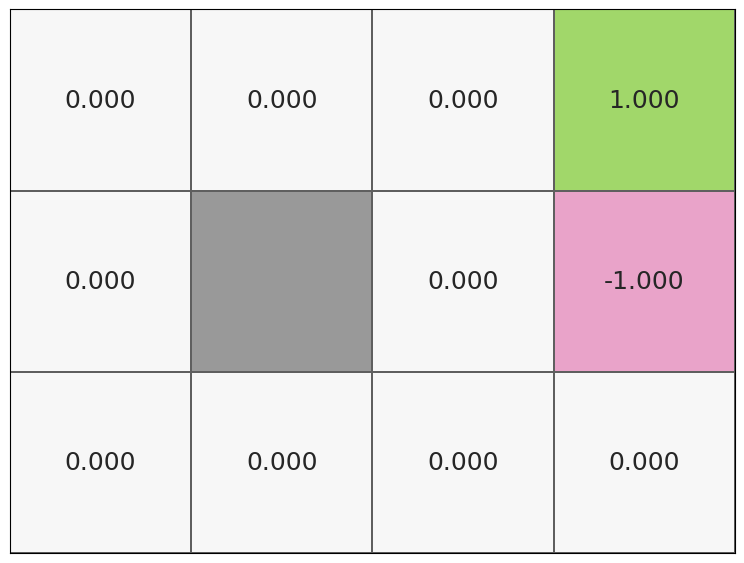

In [14]:
plot_state_rewards(maze, ax=None)

## Second example: a slightly more complicated maze

As another example, we create a slighly more complicated maze with more walls, but two terminal states with rewards -1 and 1 as before. We also add a living cost of -0.04 for each step.

In [15]:
maze_config = {
    'size': (5, 7),
    'walls': [(1,1), (1,2), (1,3), (2,1), (3,1),
              (3,3), (3,4), (3,5), (2,5), (3,5) ],
    'terminal_states': [(2,3), (1,5)],
    'rewards': {
        (2,3): 1,
        (1,5): -1
    }
}
maze = Maze(maze_config, gamma=0.9, living_cost = -0.04)

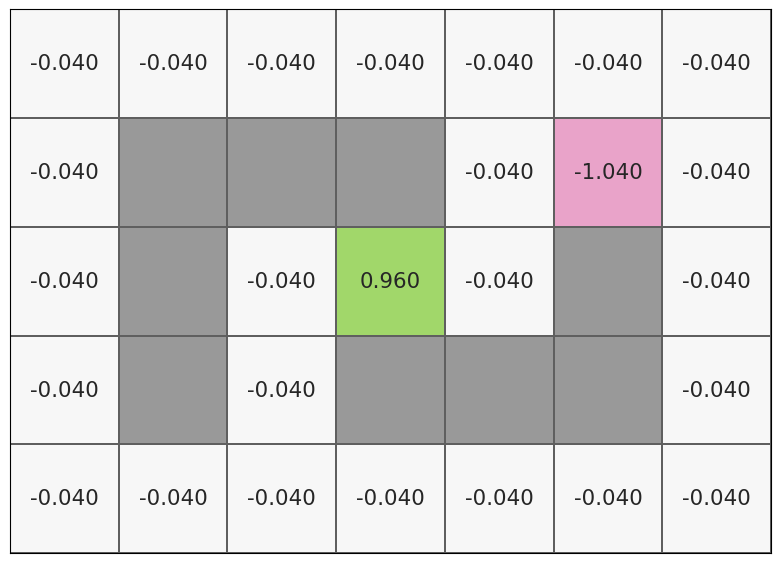

In [16]:
plot_state_rewards(maze, ax=None)

## Example: State values displayed on maze grid

We initialize the state values to random values and show the values on the maze grid. Note that we consider value of terminal states to be zero as there will be no future rewards available after entering a terminal state.

{(0, 0): 0.7853811504901005,
 (0, 1): 0.39217787044848484,
 (0, 2): 0.3028666182027946,
 (0, 3): 0.8706420046246166,
 (0, 4): 0.3910292187522356,
 (0, 5): 0.18614187769610424,
 (0, 6): 0.46048783099873314,
 (1, 0): 0.46759568188133016,
 (1, 4): 0.12115719306457551,
 (1, 5): 0,
 (1, 6): 0.09197145368214465,
 (2, 0): 0.6226541258963881,
 (2, 2): 0.7684129966769524,
 (2, 3): 0,
 (2, 4): 0.24823302910056122,
 (2, 6): 0.8660238265274101,
 (3, 0): 0.3537875108122429,
 (3, 2): 0.4074071914286955,
 (3, 6): 0.6013043973815427,
 (4, 0): 0.46089134244045304,
 (4, 1): 0.6506684590014116,
 (4, 2): 0.35637955716467307,
 (4, 3): 0.40362349025292454,
 (4, 4): 0.33198646742866034,
 (4, 5): 0.1365669685649088,
 (4, 6): 0.4133935746272983}

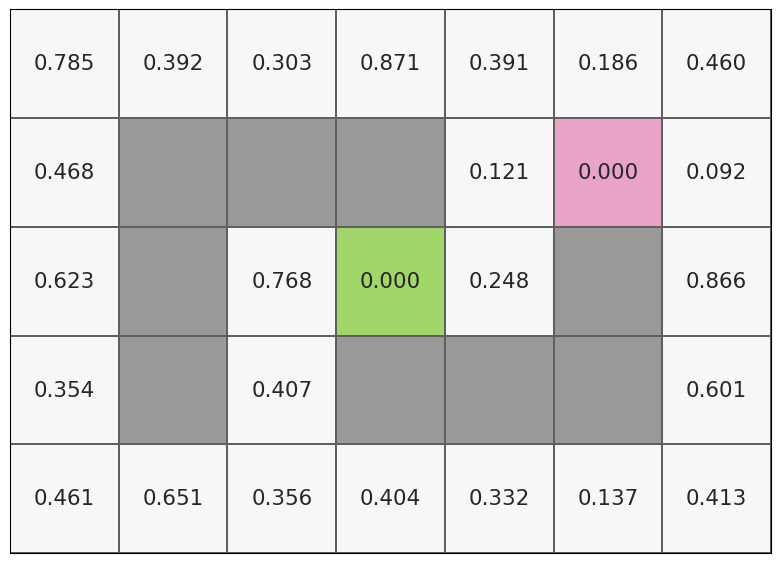

In [17]:
random_values = { state: 0 if maze.terminal[state] else np.random.rand() for state in maze.get_iterator("states") }

display(random_values)
plot_state_values(maze, random_values, ax=None)

## Example:  Policy actions displayed on maze grid

As the final example, we create a random policy and visualize the policy on the maze grid

{(0, 0): 2,
 (0, 1): 0,
 (0, 2): 2,
 (0, 3): 0,
 (0, 4): 2,
 (0, 5): 0,
 (0, 6): 3,
 (1, 0): 2,
 (1, 4): 2,
 (1, 6): 2,
 (2, 0): 2,
 (2, 2): 0,
 (2, 4): 1,
 (2, 6): 3,
 (3, 0): 1,
 (3, 2): 0,
 (3, 6): 3,
 (4, 0): 0,
 (4, 1): 3,
 (4, 2): 0,
 (4, 3): 3,
 (4, 4): 2,
 (4, 5): 0,
 (4, 6): 3}

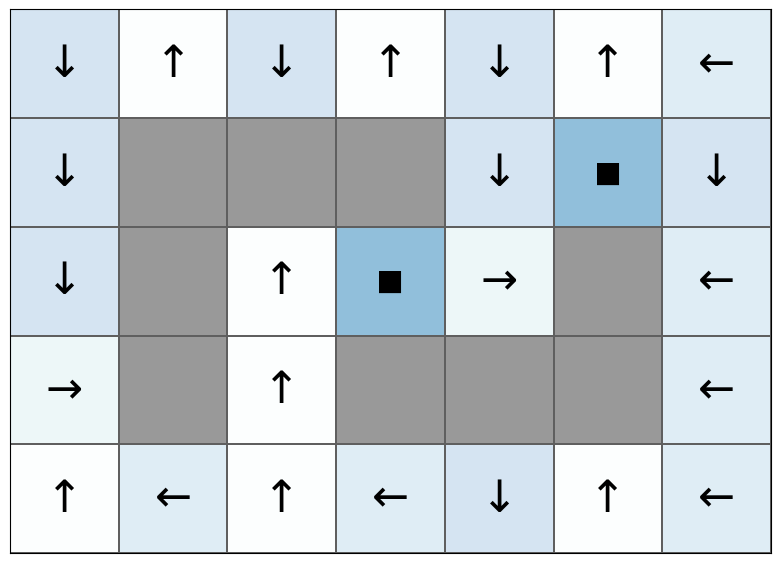

In [18]:
policy = {}

for state in maze.get_iterator("states"):

    if maze.terminal[state]:
        continue

    policy[state] = np.random.choice(Movement.actions)

display(policy)
plot_policy_actions(maze, policy)